In [85]:
def simulate_margin(products, dates, loc, scale):
    import numpy as np
    import pandas as pd

    n_products = len(products)
    n_days = len(dates)    

    scale_diff = scale/np.sqrt(n_days)
    product_baseline = np.random.normal(loc=loc,scale=scale,size=(n_products,1))
    product_diff = np.random.normal(loc=0, scale=scale_diff, size=(n_products, n_days-1))
    margins = np.cumsum(np.concatenate([product_baseline, product_diff], axis=1), axis=1)
    margins = pd.DataFrame(margins, columns=dates)
    margins["product_id"] = products
    return margins

def plot_simulated_data(data, x, y, hue):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1,2, figsize=(20,7.5))
    # walk
    sns.lineplot(data=data,
        x=x, y=y, hue=hue,
        legend=False, palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5, ax=axs[0]);
    axs[0].set_ylabel(y);
    axs[0].tick_params(axis='x', rotation=90);
    axs[0].set_xlabel(x);
    # hist
    sns.histplot(data=data,
        x=y, bins=50,
        color=sns.color_palette("rocket",10)[1],
        ax=axs[1]);
    axs[1].set_ylabel("frequency");
    axs[1].set_xlabel(y);

def get_purchases(path="../data/raw/retailrocket/events"):
    import numpy as np
    import pandas as pd

    events = pd.read_parquet(path).drop_duplicates()
    purchases = events[events.event_type_name=="purchase"]
    purchases.loc[:,"date"] = purchases.event_time.dt.date
    purchases["week_start"] = purchases["date"] -\
        pd.to_timedelta(purchases["event_time"].dt.dayofweek, unit="d")
    return purchases    

def get_acp(purchases, margins, target_size=4):
    import pandas as pd
    from itertools import product

    purchases = purchases.merge(margins, on=["product_id","date"], how="inner")
    purchases["profit"] = purchases.revenue*purchases.margin
    purchases = purchases.groupby(["user_id", "week_start"], as_index=False)\
        .agg(profit=("profit", sum), revenue=("revenue", sum))
    user_week_product = product(purchases.user_id.unique(), purchases.week_start.unique())
    user_acp = pd.DataFrame(user_week_product, columns=["user_id", "week_start"])\
        .merge(purchases, on=["user_id", "week_start"], how="left")\
            .fillna(0).sort_values("week_start")\
                .rename(columns={"week_start":"date"})
    user_acp["acp"] = target_size*user_acp.groupby("user_id").profit.cumsum()/\
        (user_acp.groupby("user_id").cumcount()+1)
    return user_acp.loc[:,["user_id", "date", "acp"]]

def simulate_acp(purchases, loc, scale, seed=0):
    import numpy as np
    import pandas as pd
    
    np.random.seed(seed)
    dates = purchases.sort_values("week_start").week_start.unique()
    products = purchases.product_id.unique()
    margins = simulate_margin(products, dates, loc, scale)
    margins = pd.melt(margins, id_vars=["product_id"],
            var_name="date", value_name="margin")
    user_acp = get_acp(purchases, margins, 4)
    return pd.DataFrame([[loc, scale, seed, user_acp.acp.mean(), user_acp.acp.std()]],
        columns=["loc","scale", "seed", "mu", "sigma"])        

### Simulate margin & estimate ACP

/tmp/ipykernel_178/1624916460.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:,"date"] = purchases.event_time.dt.date
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(
/tmp/ipykernel_178/1624916460.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases["week_start"] = purchases["date"] -\


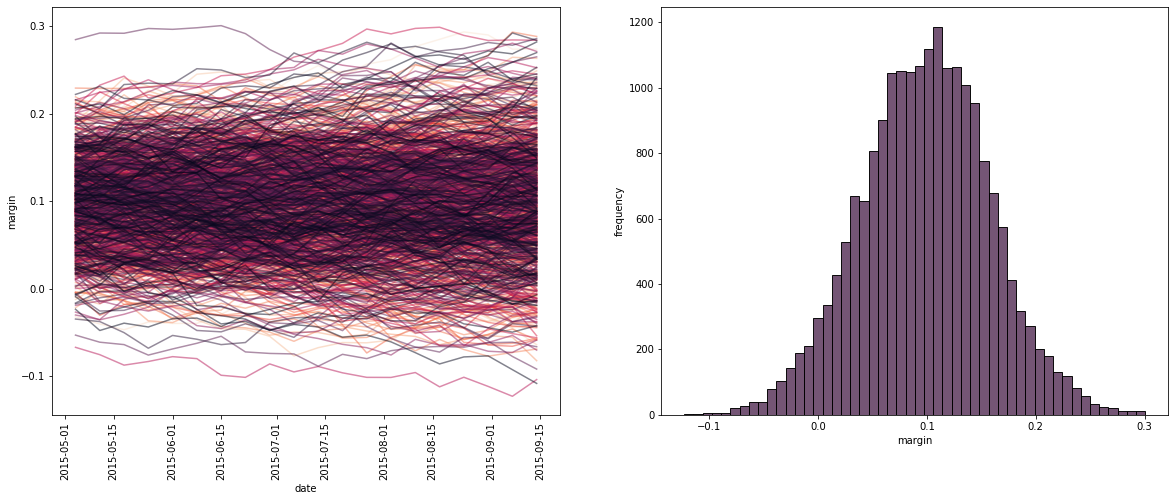

In [73]:
# SIMULATE MARGINS
import pandas as pd
purchases = get_purchases()
# simulation
loc = 0.10
scale = 0.05
dates = purchases.sort_values("week_start").week_start.unique()
products = purchases.product_id.unique()
margins = simulate_margin(products, dates, loc, scale)
margins = pd.melt(margins, id_vars=["product_id"],
        var_name="date", value_name="margin")
# plot
prod_subset = margins.product_id.isin(margins.product_id.unique()[:1000])    
plot_simulated_data(margins[prod_subset], x="date", y="margin", hue="product_id")    

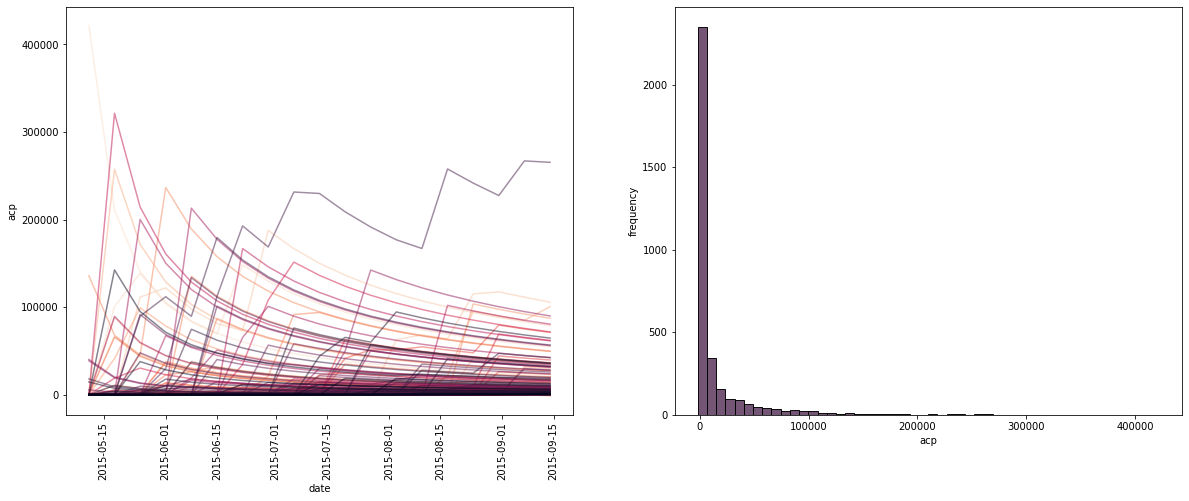

In [75]:
user_acp =  get_acp(purchases, margins, target_size=4)
plot_simulated_data(user_acp, x="date", y="acp", hue="user_id")

### Sensitivity analysis

In [142]:
from itertools import product
import numpy as np
from multiprocessing import Pool

mu_range = np.linspace(0.05,0.5,10)
sigma_range = np.linspace(0.01,0.1,10)
seed_range = np.random.randint(low=0, high=2**16, size=100)

def para_sacp(params):
    return simulate_acp(purchases,
        params[0], params[1], params[2])

with Pool() as poo:
    sensitivity_sim = poo.map(para_sacp,
        product(mu_range, sigma_range, seed_range))
sensitivity_sim =  pd.concat(sensitivity_sim)  

In [164]:
def plot_sensitivity(space):
    import numpy as np
    from scipy.interpolate import griddata
    import matplotlib.pyplot as plt
    from matplotlib import ticker
    
    X, Y, Z = space["loc"], space["scale"], space["sigma"]
    plotx, ploty = np.meshgrid(
        np.linspace(np.min(X),np.max(X),25),
        np.linspace(np.min(Y),np.max(Y),25))
    plotz = griddata((X,Y), Z, (plotx, ploty), method="cubic")

    fig = plt.figure(figsize=(17,12))
    ax = fig.add_subplot(111, projection="3d")
    #ax.view_init(elev=50, azim=30)
    ax.plot_surface(plotx, ploty, plotz, cmap="rocket")
    ax.set_xlabel("$\mu_0$")
    ax.set_ylabel("$\sigma_0$")
    ax.set_zlabel("acp")
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2,2))
    ax.w_zaxis.set_major_formatter(formatter)    
    return ax

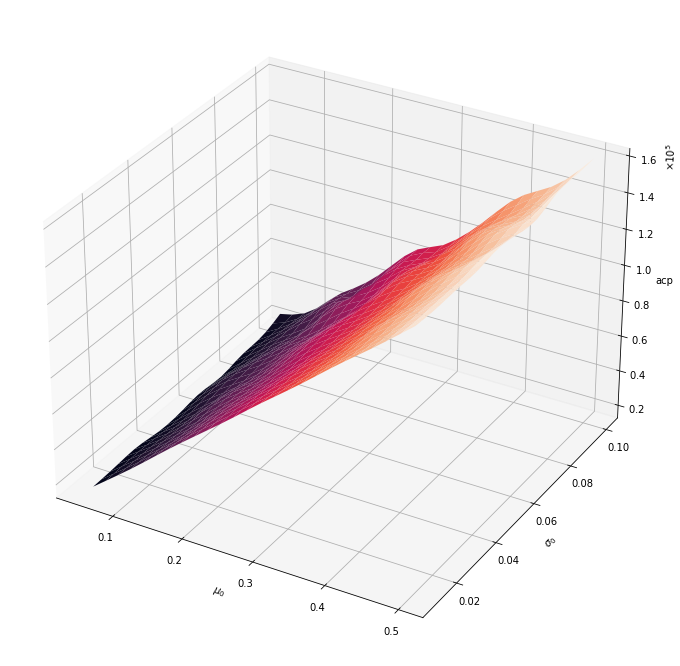

In [165]:
plot_sensitivity(sensitivity_sim);

In [ ]:
# SCIENTIFIC NOTATION ON Z - DONE
# CLEAN UP THE FUNCTIONS
# CONSIDER FORMATTIN DICT FOR PLOT LABS
# IMPROVE PLOT FORMATTING

# RE-RUN ON REES?

In [ ]:
# DEVELOP TOY EXAMPLE FOR THE PROFIT SIM AND EVAL